In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.regressor import PredictionError

from lazypredict import LazyRegressor


In [335]:
df = pd.read_csv('houses_to_buy.csv')

In [336]:
df.head()

,Způsob_koupě,Typ_obydlení,Počet_pokojů,Typ_kuchyně,Velikost_bytu,Cena,Ulice,Kraj
0,prodej,bytu,3,k,60,10129050,"Pražská, Praha 10 - Hostivař",1
1,prodej,bytu,1,k,32,6900000,"Počernická, Praha 10",1
2,prodej,bytu,2,k,51,6499000,Praha 10 - Vršovice,1
3,prodej,bytu,3,k,69,7490000,"Přímětická, Praha 4 - Michle",1
4,prodej,bytu,2,1,52,5250000,"Šumperská, Praha 9 - Letňany",1


In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14462 entries, 0 to 14461
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Způsob_koupě   14462 non-null  object
 1   Typ_obydlení   14462 non-null  object
 2   Počet_pokojů   14462 non-null  int64 
 3   Typ_kuchyně    14462 non-null  object
 4   Velikost_bytu  14462 non-null  int64 
 5   Cena           14462 non-null  int64 
 6   Ulice          14462 non-null  object
 7   Kraj           14462 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 904.0+ KB


In [338]:
for column in df.columns:
    print(df[column].value_counts())

Způsob_koupě
prodej    14227
0           235
Name: count, dtype: int64
Typ_obydlení
bytu    14227
0         235
Name: count, dtype: int64
Počet_pokojů
3    5206
2    5066
1    2077
4    1584
5     262
0     235
6      32
Name: count, dtype: int64
Typ_kuchyně
k    8410
1    5817
0     235
Name: count, dtype: int64
Velikost_bytu
54     342
60     333
65     287
62     266
70     263
      ... 
255      1
223      1
210      1
272      1
211      1
Name: count, Length: 271, dtype: int64
Cena
0          929
3990000    203
4990000    118
2990000     99
5990000     92
          ... 
9137820      1
5198456      1
5135990      1
4884906      1
2339000      1
Name: count, Length: 4229, dtype: int64
Ulice
Pražská, Praha 10 - Hostivař            198
Hodkovická, Praha 4 - Kamýk             103
Radlická, Praha 5 - Radlice              97
Ostašova, Kutná Hora - Hlouška           79
Hábova, Praha 5 - Stodůlky               67
                                       ... 
Závodní, Karlovy Vary - Dvory  

In [339]:
df.describe()

,Počet_pokojů,Velikost_bytu,Cena,Kraj
count,14462.00,14462.00,14462.00,14462.00
mean,2.47,70.68,5615321.22,5.51
std,0.99,37.45,10147417.12,4.28
min,0.00,0.00,0.00,1.00
25%,2.00,51.00,2550000.00,1.00
50%,2.00,65.00,4390000.00,5.00
75%,3.00,82.00,7126002.75,10.00
max,6.00,985.00,606868961.00,14.00


In [340]:
def preprocess(df):
    
    df = pd.DataFrame(data= df.values, columns=['Purchase_method', 'House_type', 'Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Street', 'Region'])
    df = df.drop(columns=['Purchase_method', 'House_type', 'Street'])
    df = df.query('Kitchen_type != "0"')
    df['Kitchen_type'] = df['Kitchen_type'].apply(lambda x: 0 if x == 'k' else 1)
    regions = pd.read_csv('regions.csv')
    regions['Region'] = regions['id']
    df = df.merge(regions, on= 'Region', how = 'inner')
    df = df.drop(columns=['Region', 'id'])
    df['Number_of_rooms'] = df['Number_of_rooms'].astype(int)
    df['M2'] = df['M2'].astype(int)
    df['Price'] = df['Price'].astype(int)
    
    enc = OneHotEncoder()
    enc.fit(df[['kraj']])
    new = enc.transform(df[['kraj']]).toarray()
    data= pd.DataFrame(data= new, columns= enc.get_feature_names_out())
    df = pd.concat([df, data], axis= 1)
    df = df.drop(columns= ['kraj'])
    df = pd.DataFrame(data= df.values, columns= ['Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Praha', 'Jihomoravský', 
                                                 'Jihočeský', 'Karlovarský', 'Královéhradecký', 'Liberecký', 'Moravskoslezský', 'Olomoucký ', 'Pardubický', 
                                                 'Plzeňský', 'Středočeský', 'Zlínský', 'Vysočina', 'Ústecký'])

    
    return df

def train(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns= 'Price'),
        df['Price'],
        train_size= 0.8,
        random_state= 34
    )
    
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    y_pred = lin.predict(X_test)
    
    plt.figure(figsize = (8,8))

    linear_wf_test_error = PredictionError(lin, is_fitted = True, bestfit = False, alpha = 0.3)
    linear_wf_test_error.score(X_test, y_test)
    linear_wf_test_error.show()
       

In [341]:
df = preprocess(df)

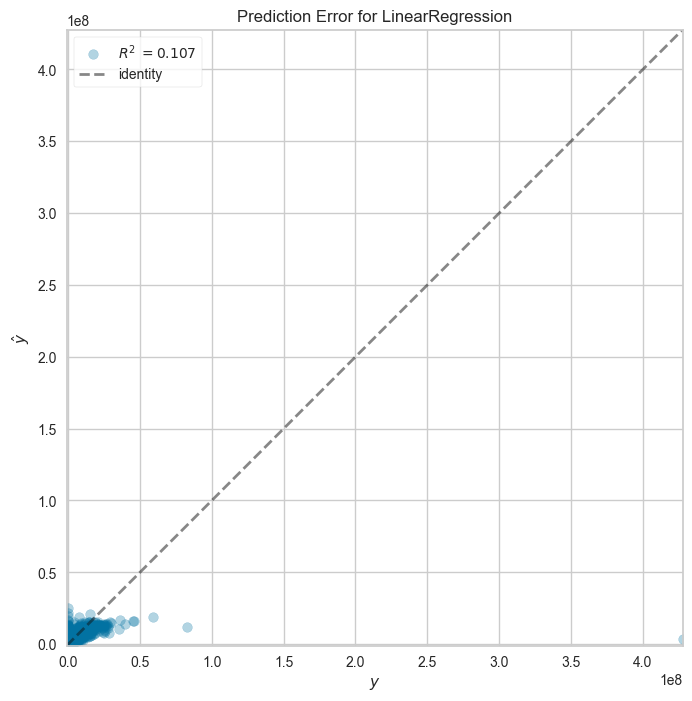

In [342]:
train(df)

## Beyond the base model

(array([1.422e+04, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([0.00000000e+00, 6.06868961e+07, 1.21373792e+08, 1.82060688e+08,
        2.42747584e+08, 3.03434480e+08, 3.64121377e+08, 4.24808273e+08,
        4.85495169e+08, 5.46182065e+08, 6.06868961e+08]),
 <BarContainer object of 10 artists>)

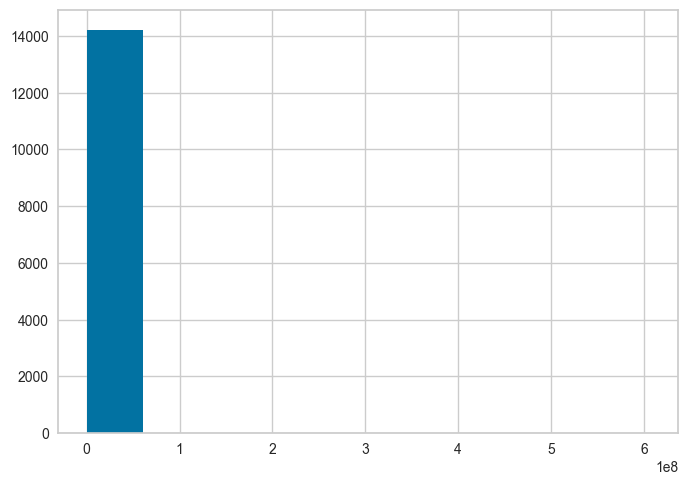

In [343]:
plt.hist(df['Price'])

(array([5.600e+01, 1.746e+03, 4.068e+03, 4.255e+03, 2.102e+03, 9.690e+02,
        4.430e+02, 2.180e+02, 1.440e+02, 7.100e+01, 5.600e+01, 2.500e+01,
        2.400e+01, 1.700e+01, 1.500e+01, 2.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([  1.  ,  20.68,  40.36,  60.04,  79.72,  99.4 , 119.08, 138.76,
        158.44, 178.12, 197.8 , 217.48, 237.16, 256.84, 276.52, 296.2 ,
        315.88, 335.56, 355.24, 374.92, 394.6 , 414.28, 433.96, 453.64,
        473.32, 493.  , 512.68, 532.36, 552.04, 571.72, 591.4 , 611.08,
        630.76, 650.44, 670.12, 689.8 , 709.48, 729.16, 748.84, 768.52,
        788.2 , 

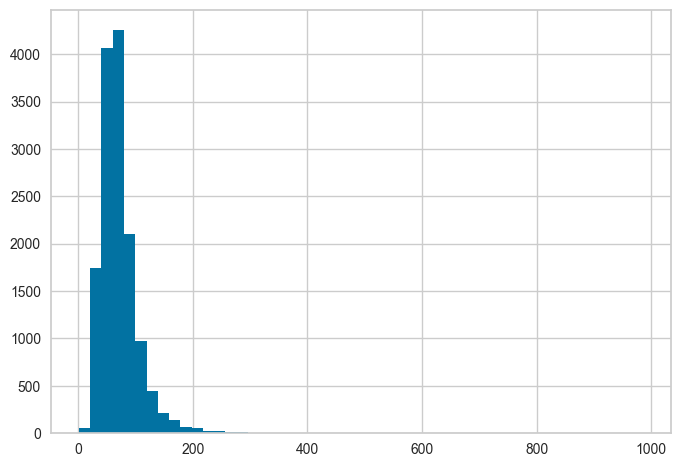

In [344]:
plt.hist(df['M2'], bins = 50)

In [345]:
df = df.query('Price < 100000000')

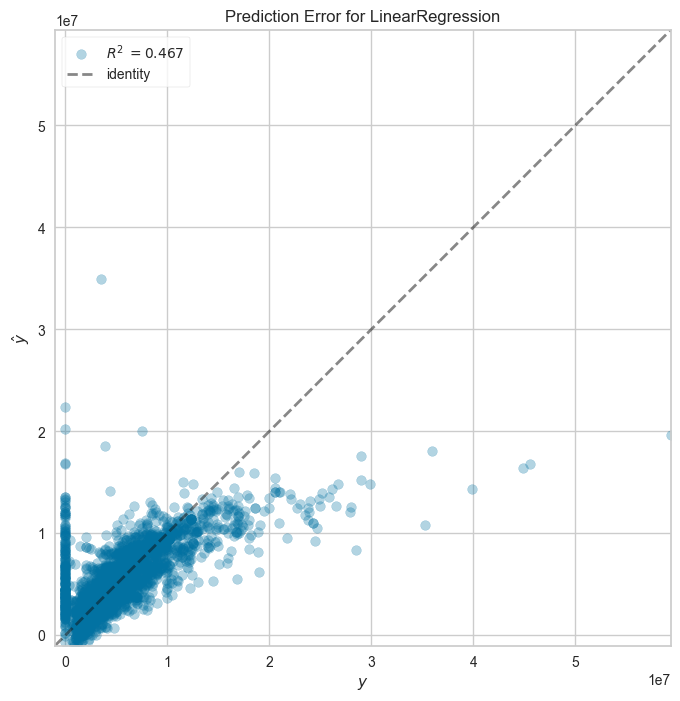

In [346]:
train(df)

In [347]:
df_less = df.query('Price < 100000')
df_less

,Number_of_rooms,Kitchen_type,M2,Price,Praha,Jihomoravský,Jihočeský,Karlovarský,Královéhradecký,Liberecký,Moravskoslezský,Olomoucký,Pardubický,Plzeňský,Středočeský,Zlínský,Vysočina,Ústecký
19,3.00,0.00,136.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,3.00,1.00,95.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
68,2.00,1.00,58.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70,3.00,1.00,71.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
140,2.00,0.00,62.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14201,2.00,1.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14207,3.00,0.00,65.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14208,3.00,0.00,70.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14213,3.00,1.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


# Removing houses with invalid prices

In [348]:
df = df.query('Price > 100000')

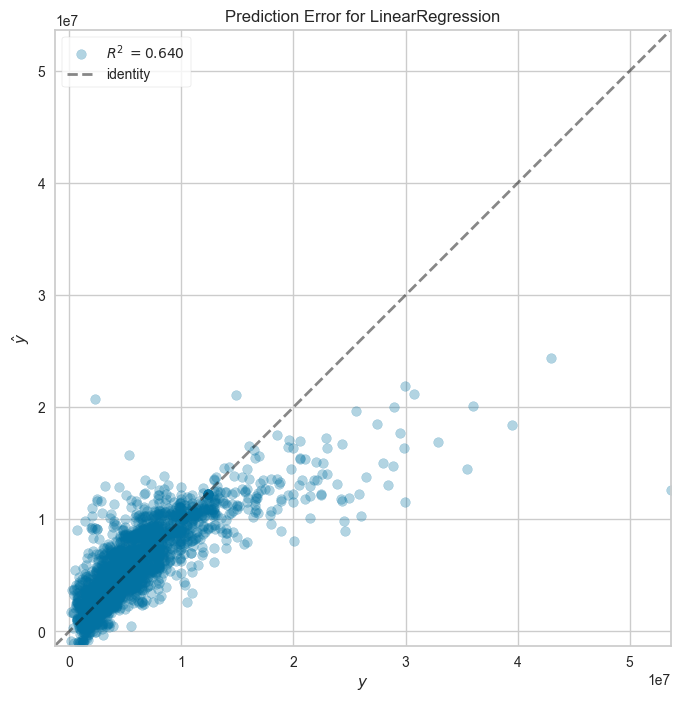

In [349]:
train(df)

## Upgrading Preprocessing

In [350]:
def preprocess(df):
    
    df = pd.DataFrame(data= df.values, columns=['Purchase_method', 'House_type', 'Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Street', 'Region'])
    df = df.drop(columns=['Purchase_method', 'House_type', 'Street'])
    df = df.query('Kitchen_type != "0"')
    df['Kitchen_type'] = df['Kitchen_type'].apply(lambda x: 0 if x == 'k' else 1)
    regions = pd.read_csv('regions.csv')
    regions['Region'] = regions['id']
    df = df.merge(regions, on= 'Region', how = 'inner')
    df = df.drop(columns=['Region', 'id'])
    df['Number_of_rooms'] = df['Number_of_rooms'].astype(int)
    df['M2'] = df['M2'].astype(int)
    df['Price'] = df['Price'].astype(int)
    
    enc = OneHotEncoder()
    enc.fit(df[['kraj']])
    new = enc.transform(df[['kraj']]).toarray()
    data= pd.DataFrame(data= new, columns= enc.get_feature_names_out())
    df = pd.concat([df, data], axis= 1)
    df = df.drop(columns= ['kraj'])
    df = pd.DataFrame(data= df.values, columns= ['Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Praha', 'Jihomoravský', 
                                                 'Jihočeský', 'Karlovarský', 'Královéhradecký', 'Liberecký', 'Moravskoslezský', 'Olomoucký ', 'Pardubický', 
                                                 'Plzeňský', 'Středočeský', 'Zlínský', 'Vysočina', 'Ústecký'])
    
    df = df.query('Price > 800000 & Price < 25000000')
    df = df.query('M2 < 200 & M2 > 15')
    return df
    
def train(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns= 'Price'),
        df['Price'],
        train_size= 0.8,
        random_state= 34
    )
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(data= scaled, columns= scaler.get_feature_names_out()) 
    
    X_test = scaler.transform(X_test) 
    
    lin = LinearRegression()
    lin.fit(X_train_scaled, y_train)
    y_pred = lin.predict(X_test)
    
    plt.figure(figsize = (8,8))

    linear_wf_test_error = PredictionError(lin, is_fitted = True, bestfit = False, alpha = 0.3)
    linear_wf_test_error.score(X_test, y_test)
    linear_wf_test_error.show()
    
    return df

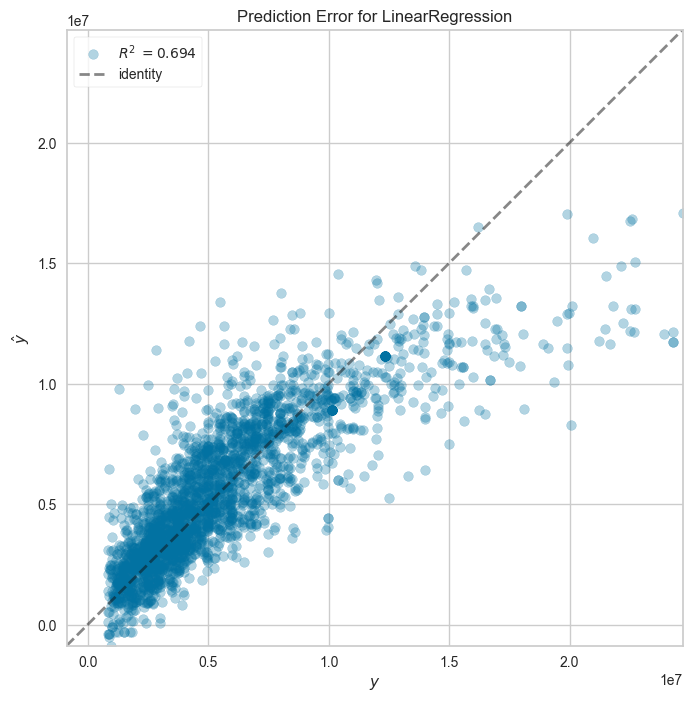

,Number_of_rooms,Kitchen_type,M2,Price,Praha,Jihomoravský,Jihočeský,Karlovarský,Královéhradecký,Liberecký,Moravskoslezský,Olomoucký,Pardubický,Plzeňský,Středočeský,Zlínský,Vysočina,Ústecký
0,3.00,0.00,60.00,10129050.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,0.00,32.00,6900000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,0.00,51.00,6499000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.00,0.00,69.00,7490000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2.00,1.00,52.00,5250000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14222,3.00,1.00,81.00,3690000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14223,1.00,0.00,34.00,2329000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14224,2.00,0.00,45.00,2949000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
14225,2.00,0.00,45.00,2939000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [351]:
df = pd.read_csv('houses_to_buy.csv')
df = preprocess(df)
train(df)

# Using Lazypredict to find the best model

In [352]:
def train(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns= 'Price'),
        df['Price'],
        train_size= 0.8,
        random_state= 34
    )
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(data= scaled, columns= scaler.get_feature_names_out()) 
    
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(data= X_test_scaled, columns= scaler.get_feature_names_out()) 
    
    
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test) 
    
    return models

In [353]:
models = train(df)
print(models)

100%|██████████| 42/42 [01:08<00:00,  1.62s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 10378, number of used features: 17
[LightGBM] [Info] Start training from score 5691520.693197
                               Adjusted R-Squared  R-Squared          RMSE  \
Model                                                                        
LGBMRegressor                                0.76       0.76    1812299.75   
HistGradientBoostingRegressor                0.76       0.76    1821220.03   
GradientBoostingRegressor                    0.75       0.75    1854127.51   
XGBRegressor                                 0.75       0.75    1854191.01   
KNeighborsRegressor                          0.74       0.74    1885212.92   
RandomForestRegressor                      

## Final prediction

In [354]:
from sklearn.ensemble import GradientBoostingRegressor

In [355]:
df = pd.read_csv('houses.csv')

In [356]:
def preprocess(df):
    
    df = pd.DataFrame(data= df.values, columns=['Purchase_method', 'House_type', 'Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Street', 'Region'])
    df = df.drop(columns=['Purchase_method', 'House_type', 'Street'])
    df = df.query('Kitchen_type != "0"')
    df['Kitchen_type'] = df['Kitchen_type'].apply(lambda x: 0 if x == 'k' else 1)
    regions = pd.read_csv('regions.csv')
    regions['Region'] = regions['id']
    df = df.merge(regions, on= 'Region', how = 'inner')
    df = df.drop(columns=['Region', 'id'])
    df['Number_of_rooms'] = df['Number_of_rooms'].astype(int)
    df['M2'] = df['M2'].astype(int)
    df['Price'] = df['Price'].astype(int)
    
    enc = OneHotEncoder()
    enc.fit(df[['kraj']])
    new = enc.transform(df[['kraj']]).toarray()
    data= pd.DataFrame(data= new, columns= enc.get_feature_names_out())
    df = pd.concat([df, data], axis= 1)
    df = df.drop(columns= ['kraj'])
    df = pd.DataFrame(data= df.values, columns= ['Number_of_rooms', 'Kitchen_type', 'M2', 'Price', 'Praha', 'Jihomoravský', 
                                                 'Jihočeský', 'Karlovarský', 'Královéhradecký', 'Liberecký', 'Moravskoslezský', 'Olomoucký ', 'Pardubický', 
                                                 'Plzeňský', 'Středočeský', 'Zlínský', 'Vysočina', 'Ústecký'])
    
    df = df.query('Price > 800000 & Price < 25000000')
    df = df.query('M2 < 200 & M2 > 15')
    return df
    
def train(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns= 'Price'),
        df['Price'],
        train_size= 0.8,
        random_state= 34
    )
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(data= scaled, columns= scaler.get_feature_names_out()) 
    
    X_test = scaler.transform(X_test) 
    
    Grad = GradientBoostingRegressor()
    Grad.fit(X_train_scaled, y_train)
    
    plt.figure(figsize = (8,8))

    linear_wf_test_error = PredictionError(Grad, is_fitted = True, bestfit = False, alpha = 0.3)
    linear_wf_test_error.score(X_test, y_test)
    linear_wf_test_error.show()
    
    return Grad

In [357]:
df = preprocess(df)

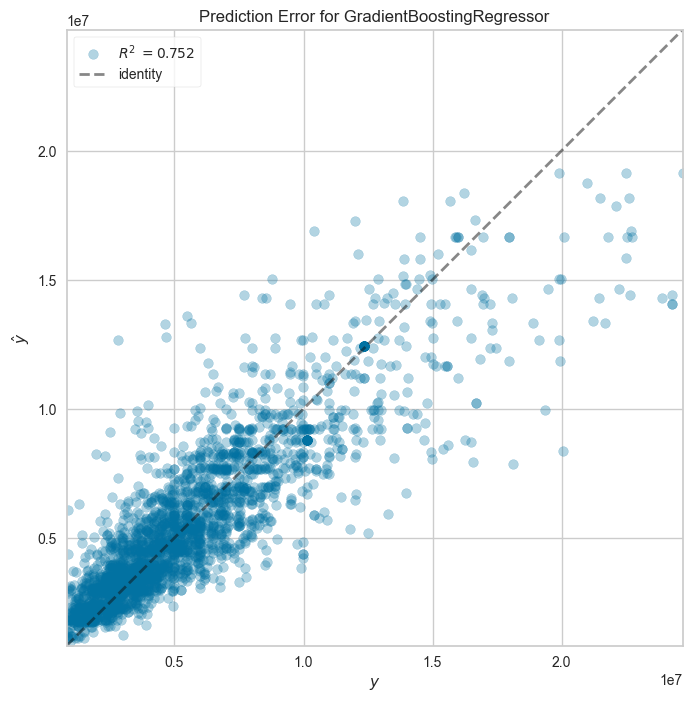

['prediction_model.pkl']

In [358]:
Model = train(df)
joblib.dump(Model, 'prediction_model.pkl')

In [359]:
Model.feature_names_in_

array(['Number_of_rooms', 'Kitchen_type', 'M2', 'Praha', 'Jihomoravský',
       'Jihočeský', 'Karlovarský', 'Královéhradecký', 'Liberecký',
       'Moravskoslezský', 'Olomoucký ', 'Pardubický', 'Plzeňský',
       'Středočeský', 'Zlínský', 'Vysočina', 'Ústecký'], dtype=object)

In [360]:
Model.feature_importances_

array([1.76375527e-02, 8.61171667e-02, 4.67429791e-01, 3.87557675e-01,
       1.05500457e-02, 5.57330999e-05, 1.86304521e-03, 3.71699728e-04,
       2.14031375e-04, 4.65520111e-03, 2.29846343e-04, 6.80469265e-04,
       1.12809176e-04, 8.04418857e-03, 6.24784894e-05, 1.02910738e-03,
       1.33891597e-02])

In [361]:
df.Number_of_rooms.max(), df.M2.max()

(6.0, 199.0)

In [362]:
df.Number_of_rooms.min(), df.M2.min()

(1.0, 16.0)